## Random Forest Regession Implementation step by step

Most of the code is copied and modifed from the different implementations in Notes.ipynb, take aways from the previous version that needs chaning implementation to t+24h forcast instead of t+6h. This along with energy data is seen as "true" meaning it cannot be used for training and testing straight away. Instead you would need to have it as a seperate target which sounds like a headace because boa is affected by the market and I'm not even going to attempt. Regardless something simple coud be tested to be implemented but only if time is avalible.

In [1]:
# Import Libraries and preprocces data
import numpy as np
import pandas as pd
import xarray as xr

from datetime import timedelta

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error

model_table = pd.read_csv("data/forecast_data_merged_3.csv")
# convert to datetime
model_table["ref_datetime"] = pd.to_datetime(model_table["ref_datetime"])
model_table["valid_datetime"] = pd.to_datetime(model_table["valid_datetime"])

In [2]:
# Drop the True values
columns_to_remove = ["dtm", "Solar_MW", "Wind_MW", 
                    "wind_curtailment_MW", "wind_potential_MW", 
                    "Solar_MWh_credit", "Wind_MWh_credit",
                    "total_generation_MWh"]

model_table = model_table.drop(columns_to_remove, axis=1)
display(model_table)

,ref_datetime,valid_datetime,dwd_RelativeHumidity,dwd_WindDirection_100,dwd_WindSpeed_100,dwd_CloudCover,dwd_SolarDownwardRadiation,dwd_Temperature,ncep_RelativeHumidity,ncep_WindDirection_100,ncep_WindSpeed_100,ncep_CloudCover,ncep_SolarDownwardRadiation,ncep_Temperature
0,2020-09-20 00:00:00+00:00,2020-09-20 00:00:00+00:00,85.213750,62.085170,11.802604,0.450405,0.000000,13.646173,84.066666,58.721077,11.338991,0.026000,0.0,13.940016
1,2020-09-20 00:00:00+00:00,2020-09-20 00:30:00+00:00,85.012270,61.726974,11.648818,0.472211,0.000000,13.658508,84.433334,58.494644,11.516161,0.039000,0.0,13.896579
2,2020-09-20 00:00:00+00:00,2020-09-20 01:00:00+00:00,84.810780,61.368782,11.495032,0.494018,0.000000,13.670843,84.800000,58.268215,11.693331,0.052000,0.0,13.853142
3,2020-09-20 00:00:00+00:00,2020-09-20 01:30:00+00:00,84.357895,61.111046,11.354128,0.520214,0.000000,13.732101,84.933334,59.550636,11.716686,0.038500,0.0,13.847113
4,2020-09-20 00:00:00+00:00,2020-09-20 02:00:00+00:00,83.905000,60.853313,11.213223,0.546410,0.000000,13.793360,85.066666,60.833060,11.740043,0.025000,0.0,13.841084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3459719,2023-10-27 00:00:00+00:00,2023-10-27 21:30:00+00:00,80.259060,177.495090,2.620757,0.549926,-0.003020,8.741467,81.200000,203.196010,5.695431,0.144725,0.0,8.939343
3459720,2023-10-27 00:00:00+00:00,2023-10-27 22:00:00+00:00,79.186960,172.861190,2.756149,0.585028,-0.011098,8.610748,80.122220,209.989490,5.170937,0.215100,0.0,8.804339
3459721,2023-10-27 00:00:00+00:00,2023-10-27 22:30:00+00:00,79.410890,173.374680,3.079223,0.676564,-0.004312,8.533447,79.872220,208.122830,5.281261,0.369525,0.0,8.769360
3459722,2023-10-27 00:00:00+00:00,2023-10-27 23:00:00+00:00,79.634820,173.888170,3.402297,0.768100,0.002474,8.456146,79.622220,206.256160,5.391584,0.523950,0.0,8.734381


Now the fun begins, so the thing is with these forcasts is that every 6 hours we get a 50h forcast (technically more but it's not included, feel free to do so if you want). This means that the forcasts actually overlapp eachother. We need to process this before creating traning and testing splits. Unfortunetly there are a plethera of methods that can be used to handle this simplest being just cutting of the overlapping time spand to the most resent forcast, other ways consist of weight the most resent forcast being heavier, other method could be taking means of overlapping time. One could also do seperate forcasts for each of the overlaps and take the best result. But instead of writing funny words, let's do 2 different types of additional preprocessing:

1. numero uno taking the most resent forcast 
2. numero dos taking the mean over overlapping forcasts.

## Additional Preprocessing of data generally

välkommen till mitt personliga helvete

In [3]:
# Som man kan säga första lösningen är sällan den bästa, detta är en förnyad version av mitt tiddiagre prepross scritps 

## le dernier est le meilleur; den senaste är den bästa 
# Assuming the lastest forcast is the best forcast
X_latest_forcast = pd.DataFrame() 
num_day = model_table["ref_datetime"].dt.date.nunique()
# print(num_day)
# 1133 good value 

first_day = pd.Timestamp("2020-09-20 00:00:00+00:00")

# Now we mask for all day, bit slow but it works
for d in range(num_day):
       start = (first_day + timedelta(hours=18)) + timedelta(days=d)
       end = start + timedelta(hours=24)
       mask = (model_table["ref_datetime"] == start) &\
              (model_table["valid_datetime"] >= start + timedelta(hours=6)) &\
              (model_table["valid_datetime"] < end + + timedelta(hours=6))
       X_latest_forcast = pd.concat([X_latest_forcast, model_table.loc[mask]])


## Mean of several overlapping forcasts 
X_raw = model_table.copy()

# filter for D-1
X_raw["target_day"] = X_raw["valid_datetime"].dt.date
X_raw["reference_day"] = X_raw["ref_datetime"].dt.date
X_raw_filtered = X_raw[X_raw["reference_day"] == (X_raw["target_day"] - pd.Timedelta(days=1))]

# aggregate mean, very fast very nice yes yes 
X_overlapp_mean = X_raw_filtered.groupby("valid_datetime", as_index=False).agg({
    "dwd_RelativeHumidity": "mean",
    "dwd_WindDirection_100": "mean",
    "dwd_WindSpeed_100": "mean",	
    "dwd_CloudCover": "mean",
    "dwd_SolarDownwardRadiation": "mean",	
    "dwd_Temperature": "mean",
    "ncep_RelativeHumidity": "mean",
    "ncep_WindDirection_100": "mean",
    "ncep_WindSpeed_100": "mean",
    "ncep_CloudCover": "mean",	
    "ncep_SolarDownwardRadiation": "mean",	
    "ncep_Temperature": "mean",
    "ref_datetime": ["first", "count"]  # Keep one value + count
})

# flatten the multiIndex columns
X_overlapp_mean.columns = [
    "_".join(col) if isinstance(col, tuple) else col 
    for col in X_overlapp_mean.columns
]

# rename 
X_overlapp_mean = X_overlapp_mean.rename(columns={
    "ref_datetime_first": "ref_datetime",
    "ref_datetime_count": "n_forecasts",
    "dwd_RelativeHumidity_mean": "dwd_RelativeHumidity",
    "dwd_WindDirection_100_mean": "dwd_WindDirection_100",
    "dwd_WindSpeed_100_mean": "dwd_WindSpeed_100",
    "dwd_CloudCover_mean": "dwd_CloudCover",
    "dwd_SolarDownwardRadiation_mean": "dwd_SolarDownwardRadiation",	
    "dwd_Temperature_mean": "dwd_Temperature",
    "ncep_RelativeHumidity_mean": "ncep_RelativeHumidity",
    "ncep_WindDirection_100_mean": "ncep_WindDirection_100",
    "ncep_WindSpeed_100_mean": "ncep_WindSpeed_100",
    "ncep_CloudCover_mean": "ncep_CloudCover",
    "ncep_SolarDownwardRadiation_mean": "ncep_SolarDownwardRadiation",
    "ncep_Temperature_mean": "ncep_Temperature",
    "valid_datetime_": "valid_datetime"
})


Let check so see that I didn't goof 

In [5]:
#display(X_latest_forcast) # 54336 rows × 14 columns, dates look good lets move on 
#display(X_overlapp_mean) # 54336 rows × 14 columns, 4 overlapps as it should be for 50 hours, not this is for the second version

# Gifts
#X_overlapp_mean.to_csv("data/forecast_data_om.csv", index=False)
#X_latest_forcast.to_csv("data/forecast_data_lf.csv", index=False)

Summan av kardemumman, ovandligen av datan har blandat om ordningen på målen så man måste ladda om,
notera också att från modeling_table att CVS förkastas i början av filen nu

In [ ]:
# REDO WHAT WAS DONE IN prepross.py 
energy_data = pd.read_csv("data/Energy_Data_20200920_20231027.csv")

energy_data["dtm"] = pd.to_datetime(energy_data["dtm"])

energy_data_dtm = energy_data["dtm"]
energy_data_Solar = energy_data["Solar_MW"]
energy_data_Wind = energy_data["Wind_MW"]
energy_data_wind_curtailment = energy_data["boa_MWh"]

energy_data_Solar = energy_data_Solar.sort_index()
energy_data_Solar.interpolate(method='linear', inplace=True)
energy_data["Solar_MW"] = energy_data_Solar

energy_data_Wind = energy_data_Wind.sort_index()
energy_data_Wind.interpolate(method='linear', inplace=True)
energy_data["Wind_MW"] = energy_data_Wind

energy_data_wind_curtailment = energy_data_wind_curtailment.sort_index()
energy_data_wind_curtailment.interpolate(method='linear', inplace=True)
energy_data["boa_MWh"] = energy_data_wind_curtailment

energy_data["Wind_MWh_credit"] = 0.5*energy_data["Wind_MW"] - energy_data["boa_MWh"]
energy_data["Solar_MWh_credit"] = 0.5*energy_data["Solar_MW"]
energy_data["total_generation_MWh"] = energy_data["Wind_MWh_credit"] + energy_data["Solar_MWh_credit"]

# Now we have y, note that first day has been removed as we don't have X for the first day
y_all = energy_data[["dtm", "Wind_MWh_credit", "Solar_MWh_credit", "total_generation_MWh", "boa_MWh"]][48:]

# y_all.to_csv("data/target_train.csv", index=False)
# display(y_all) # 54336 rows × 5 columns, good good same num of rows,as X, dates look good, we gucci 

okei, hyvä jotto

Currently we've got X and y but they're pretty raw, lets start cooking. These are the steps before we're done. Some of these steps will use a pipeline.

1. Verify inputs, might be redundant but in the case that X and y changes in future it can be fallaged for
2. Split X and y into solar wind and train and test
3. (pipe) Feauture engineering, this will have several internal steps
4. (pipe) Quantiles
5. (pipe) Train models
6. (pipe) Predic
7. Take combined forcast and display results 


In [7]:
# 1. Verify inputs, I'm continously checking that things don't goof 

# 2. Split intor trainin and testing
split_date = pd.Timestamp("2022-10-01 00:00:00+00:00")

# mo = mean overlapp
X_train_mo = X_overlapp_mean[X_overlapp_mean["valid_datetime"] < split_date].copy()
X_test_mo = X_overlapp_mean[X_overlapp_mean["valid_datetime"] >= split_date].copy()

# lf = latest forcast
X_train_lf = X_latest_forcast[X_latest_forcast["valid_datetime"] < split_date].copy()
X_test_lf = X_latest_forcast[X_latest_forcast["valid_datetime"] >= split_date].copy()

wind_features = ["valid_datetime","dwd_RelativeHumidity", "dwd_WindDirection_100", "dwd_WindSpeed_100",
                "ncep_RelativeHumidity", "ncep_WindDirection_100", "ncep_WindSpeed_100"]

solar_features = ["valid_datetime","dwd_CloudCover", "dwd_SolarDownwardRadiation", "dwd_Temperature",
                "ncep_CloudCover", "ncep_SolarDownwardRadiation", "ncep_Temperature"]

# seperate into solar and wind
X_train_solar_mo = X_train_mo[solar_features]
X_test_solar_mo = X_test_mo[solar_features]
X_train_wind_mo = X_train_mo[wind_features]
X_test_wind_mo = X_test_mo[wind_features]

X_train_solar_lf = X_train_lf[solar_features]
X_test_solar_lf = X_test_lf[solar_features]
X_train_wind_lf = X_train_lf[wind_features]
X_test_wind_lf = X_test_lf[wind_features]

# take out targets
y_all_train = y_all[y_all["dtm"] < split_date].copy()
y_all_test = y_all[y_all["dtm"] >= split_date].copy()

y_train_solar = y_all_train["Solar_MWh_credit"]
y_test_solar = y_all_test["Solar_MWh_credit"]

y_train_wind = y_all_train["Wind_MWh_credit"]
y_test_wind = y_all_test["Wind_MWh_credit"]

# wps = wind plus solar 
y_train_wps = y_all_train["total_generation_MWh"]
y_test_wps = y_all_test["total_generation_MWh"]

# time vectors used for verification of dates
t_train = y_all_train["dtm"]
t_test = y_all_test["dtm"]

# Check for goofy 
#display(t_train)
#display(X_train_solar_lf)
#print(len(t_train))
#print(len(X_train_solar_lf))
# Same lenght and valid datetime lines up with dtm

#display(t_test)
#display(X_test_solar_lf)
#print(len(t_test))
#print(len(X_test_solar_lf))
# Same lenght and valid datetime lines up with dtm

#print(X_test_solar_mo.head())
#print("-"*50)
#print(X_train_solar_mo.head())

In [8]:
# Custom classes

# 3. Feauter Engineering
from sklearn.base import BaseEstimator, TransformerMixin

# 3.1 Costum cyclic transformer, transforms wind if necessary
class CyclicFeatureAdder(BaseEstimator, TransformerMixin):
    def __init__(self, datetime_col = "valid_datetime", wind_dir_cols=None, drop_original=True):
        self.datetime_col = datetime_col
        self.wind_dir_cols = wind_dir_cols or []
        self.drop_original = drop_original
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_ = X.copy()
        dt_col = pd.to_datetime(X_[self.datetime_col])
        X_["hour_sin"] = np.sin(2*np.pi*(dt_col.dt.hour + dt_col.dt.minute/60)/24)
        X_["hour_cos"] = np.cos(2*np.pi*(dt_col.dt.hour + dt_col.dt.minute/60)/24)
        X_["weekday_sin"] = np.sin(2*np.pi * dt_col.dt.weekday/7)
        X_["weekday_cos"] = np.cos(2*np.pi*dt_col.dt.weekday/7)
        X_["month_sin"] = np.sin(2*np.pi*dt_col.dt.month/12)
        X_["month_cos"] = np.cos(2*np.pi*dt_col.dt.month/12)
        
        # Add cyclic wind direction features (if any)
        for col in self.wind_dir_cols:
            radians = np.deg2rad(X_[col])
            X_[f"{col}_sin"] = np.sin(radians)
            X_[f"{col}_cos"] = np.cos(radians)
            dt_col = pd.to_datetime(X_[self.datetime_col])

        # Drop original datetime and wind_dir columns if specified
        if self.drop_original:
            drop_cols = [self.datetime_col] + self.wind_dir_cols
            X_ = X_.drop(columns=drop_cols)

        return X_


# 3.2 Lag desired columns
class LagFeatureAdder(BaseEstimator, TransformerMixin):
    def __init__(self, columns, lags=[-2, -1, 0, 1, 2], drop_original=True):
        self.columns = columns
        self.lags = lags
        self.drop_original = drop_original
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_ = X.copy()
        for col in self.columns:
            for lag in self.lags:
                X_[f'{col}_lag{lag}'] = X_[col].shift(lag)

        if self.drop_original:
            X_.drop(columns=self.columns, inplace=True)
        
        return X_


# 3.3 Scaler and Imputer, with memory scale 
class SafeSI(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.imputer = SimpleImputer(strategy='mean')
        self.scaler = MinMaxScaler()
        self.feature_names_ = None
        
    def fit(self, X, y=None):
        self.imputer.fit(X)
        X_imputed = self.imputer.transform(X)
        self.scaler.fit(X_imputed)
        if hasattr(X, 'columns'):
            self.feature_names_ = X.columns.tolist()
        return self
        
    def transform(self, X):
        # Handle datetime
        if 'valid_datetime' in X.columns:
            datetime_data = X['valid_datetime']
            X = X.drop(columns=['valid_datetime'])
        else:
            datetime_data = None
            
        X_imputed = self.imputer.transform(X)
        X_scaled = self.scaler.transform(X_imputed)
        
        # Return DataFrame with datetime if available
        if datetime_data is not None:
            return pd.DataFrame(X_scaled, 
                              columns=X.columns,
                              index=X.index).assign(valid_datetime=datetime_data)
        return X_scaled



brrrrrrrrrrrrrr

Additional preprocessing steps:
1. Cyclic (works)
2. lag (works)
3. Imputer (works, but returns an array)
4. Scaler (works, but returns an array)

Great well I don't want arrays, so I'll create another costum function, 3 and 4 are now a class

Now we can start running the model


In [9]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

wind_dir_col = ["dwd_WindDirection_100", "ncep_WindDirection_100"]
wind_lag_col = ["dwd_RelativeHumidity", "dwd_WindSpeed_100",
                "ncep_RelativeHumidity", "ncep_WindSpeed_100"]
solar_lag_col = ["dwd_CloudCover", "dwd_SolarDownwardRadiation", "dwd_Temperature",
                 "ncep_CloudCover", "ncep_SolarDownwardRadiation", "ncep_Temperature"]

# Pipeline for wind data
feature_engineering_wind = Pipeline([
    ("cyclic", CyclicFeatureAdder(datetime_col="valid_datetime", wind_dir_cols=wind_dir_col, drop_original=True)),
    ("lag", LagFeatureAdder(columns=wind_lag_col, drop_original=True)),
    ("imputer and scaler", SafeSI())
    ], verbose=True)


# Pipeline for solar data
feature_engineering_solar = Pipeline([
    ("cyclic", CyclicFeatureAdder(datetime_col="valid_datetime", wind_dir_cols=None, drop_original=True)),
    ("lag", LagFeatureAdder(columns=solar_lag_col, drop_original=True)),
    ("imputer_and_scaler", SafeSI())
    ], verbose=True)

# Look at transformed sets they,
#X_train_transformed = feature_engineering_solar.fit_transform(X_test_solar_lf)
#print(X_train_transformed.head(0))
#X_train_transformed = feature_engineering_wind.fit_transform(X_train_wind_mo)
#print(X_train_transformed.head(0))



 SOLAR
[Pipeline] ............ (step 1 of 3) Processing cyclic, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing lag, total=   0.0s
[Pipeline]  (step 3 of 3) Processing imputer_and_scaler, total=   0.1s
Solar MAPE: 192011918810749.2


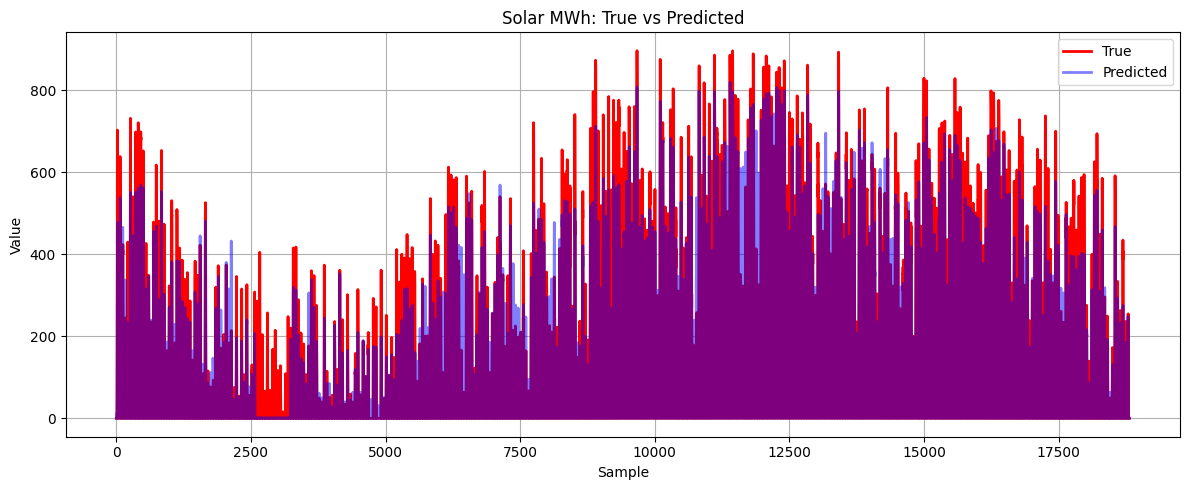


 WIND
[Pipeline] ............ (step 1 of 3) Processing cyclic, total=   0.1s
[Pipeline] ............... (step 2 of 3) Processing lag, total=   0.0s
[Pipeline]  (step 3 of 3) Processing imputer and scaler, total=   0.1s
Wind MAPE: 1.1833950292825822e+16


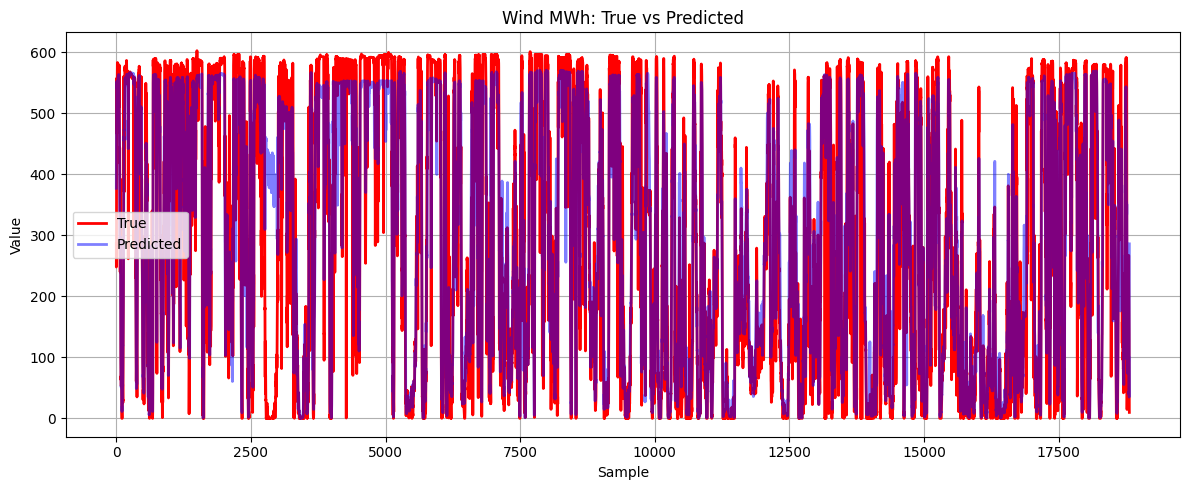

WPS MAPE: 7653490066448223.0


In [10]:
# No quantile random forest

rf_solar = RandomForestRegressor(
    n_estimators=500,
    max_depth=14,
    min_samples_split=10,    
    random_state=42,
    criterion='squared_error',
    n_jobs=-1
)

print("\n SOLAR")

solar_pipeline = Pipeline([
    ("preprocessing", feature_engineering_solar)])


X_train_solar_scaled = feature_engineering_solar.fit_transform(X_train_solar_lf, y_train_solar)
X_test_solar_scaled = feature_engineering_solar.transform(X_test_solar_lf)
rf_solar.fit(X_train_solar_scaled, y_train_solar)
y_pred_solar = rf_solar.predict(X_test_solar_scaled)

print("Solar MAPE:", mean_absolute_percentage_error(y_test_solar, y_pred_solar))

plt.figure(figsize=(12, 5))
plt.plot(y_test_solar.values, label='True', linewidth=2, color="red")
plt.plot(y_pred_solar, label='Predicted', linewidth=2, color="blue", alpha=0.5)

plt.title("Solar MWh: True vs Predicted")
plt.xlabel("Sample")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Wind model
rf_wind = RandomForestRegressor(
    n_estimators=500,
    max_depth=14,
    min_samples_split=10,    
    random_state=42,
    criterion='squared_error',
    n_jobs=-1
)

print("\n WIND")

wind_pipeline = Pipeline([
    ("preprocessing", feature_engineering_wind)])

X_train_wind_scaled = feature_engineering_wind.fit_transform(X_train_wind_lf, y_train_wind)
X_test_wind_scaled = feature_engineering_wind.transform(X_test_wind_lf)
rf_wind.fit(X_train_wind_scaled, y_train_wind)
y_pred_wind = rf_wind.predict(X_test_wind_scaled)

print("Wind MAPE:", mean_absolute_percentage_error(y_test_wind, y_pred_wind))

plt.figure(figsize=(12, 5))
plt.plot(y_test_wind.values, label='True', linewidth=2,  color="red")
plt.plot(y_pred_wind, label='Predicted', linewidth=2, color="blue", alpha=0.5)

plt.title("Wind MWh: True vs Predicted")
plt.xlabel("Sample")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# combined
y_pred_wps = y_pred_wind + y_pred_solar

print("WPS MAPE:", mean_absolute_percentage_error(y_test_wps, y_pred_wps))


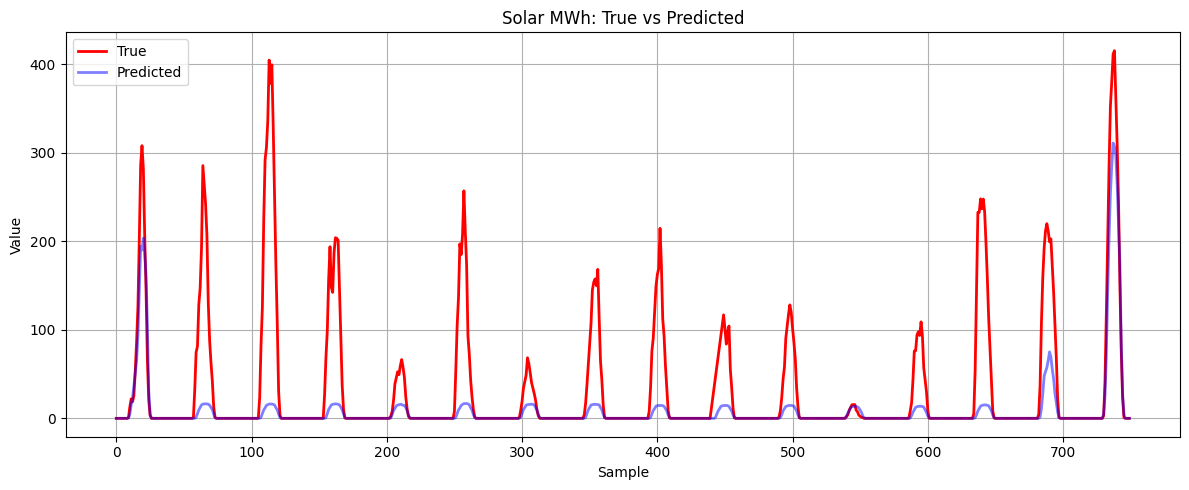

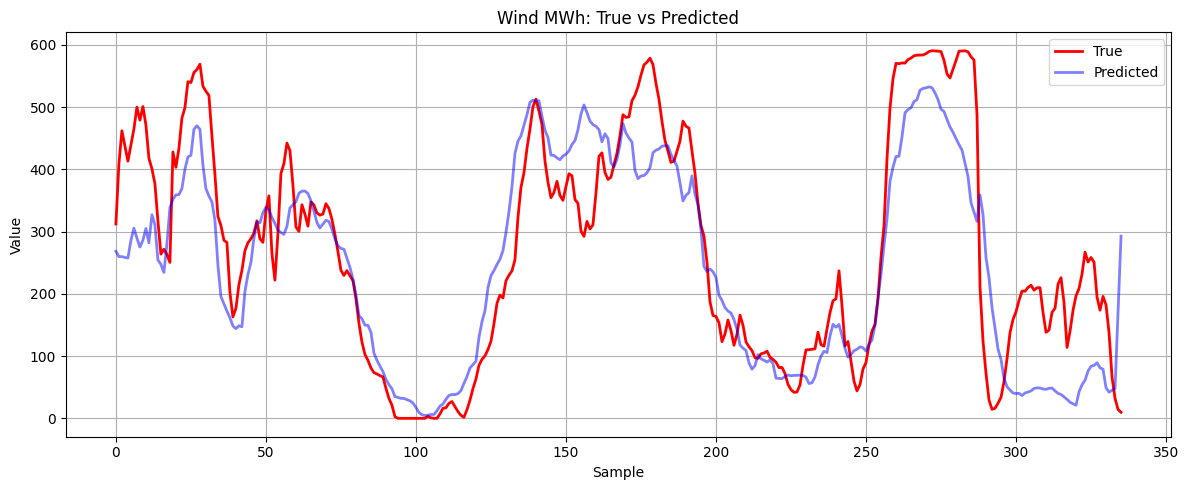

In [80]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_solar.values[2550:3300], label='True', linewidth=2, color="red")
plt.plot(y_pred_solar[2550:3300], label='Predicted', linewidth=2, color="blue", alpha=0.5)

plt.title("Solar MWh: True vs Predicted")
plt.xlabel("Sample")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#print(X_test_solar_scaled[2550:2600])
#print("-"*50)
#print(X_test_solar_scaled[2600:2650])

plt.figure(figsize=(12, 5))
plt.plot(y_test_wind.values[-336:], label='True', linewidth=2,  color="red")
plt.plot(y_pred_wind[-336:], label='Predicted', linewidth=2, color="blue", alpha=0.5)

plt.title("Wind MWh: True vs Predicted")
plt.xlabel("Sample")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Well that went well a MAPE of hipoputumous gasizlion, it's due to that we hadle values close to zero. Regardless lets move on to quantiles

In [ ]:
# quantiles using several signular models

In [ ]:
# quantiles withous spesific lib 

from quantile_forest import RandomForestQuantileRegressor

def pinball(y, q, alpha):
    return (y - q) * alpha * (y >= q) + (q - y) * (1 - alpha) * (y < q)

def pinball_score(df):
    scores = [
        pinball(
            y=df["total_generation_MWh"],
            q=df[f"q{qu}"],
            alpha=qu/100
        ).mean()
        for qu in range(10, 100, 10)
    ]
    return np.mean(scores)

def scale_target(data, scaler=None):
    is_series = isinstance(data, pd.Series)
    df = data.to_frame() if is_series else data.copy()

    numeric_cols = df.select_dtypes(include=[np.number]).columns

    if scaler is None:
        scaler = MinMaxScaler()
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    else:
        df[numeric_cols] = scaler.transform(df[numeric_cols])

    return (df.squeeze() if is_series else df), scaler

X_train_solar_scaled = feature_engineering_solar.fit_transform(X_train_solar_lf, y_train_solar)
X_test_solar_scaled = feature_engineering_solar.transform(X_test_solar_lf)

X_train_wind_scaled = feature_engineering_wind.fit_transform(X_train_wind_lf, y_train_wind)
X_test_wind_scaled = feature_engineering_wind.transform(X_test_wind_lf)

y_train_solar_scaled, y_sun_scale = scale_target(y_train_solar, scaler=None)
y_train_wind_scaled, y_wind_scale = scale_target(y_train_wind, scaler=None)


rfq_solar = RandomForestQuantileRegressor( n_estimators=500,
                                        max_depth=14,
                                        min_samples_split=10,    
                                        random_state=42,
                                        criterion="squared_error",
                                        n_jobs = -1)

print("fitting solar")
y_p_solar = rfq_solar.fit(X_train_solar_scaled, y_train_solar_scaled)

rfq_wind = RandomForestQuantileRegressor( n_estimators=500,
                                        max_depth=14,
                                        min_samples_split=10,    
                                        random_state=42,
                                        criterion="squared_error",
                                        n_jobs = -1)

print("fitting wind")
rfq_wind.fit(X_train_wind_scaled, y_train_wind_scaled)

quant = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

print("predicting solar")
y_p_solar = rfq_solar.predict(X_test_solar_scaled, quantiles=quant)

print("predicting wind")
y_p_wind = rfq_wind.predict(X_test_wind_scaled, quantiles=quant)

print("finalizing")
y_p = y_p_wind + y_p_solar

# I've gotten the runtime from over 50 min to 5 min, and for that makes me very happy

fitting solar
fitting wind
predicting solar
predicting wind
finalizing


In [12]:
#scale back output
display(y_p_wind.shape)
y_p_wind_unscaled = y_wind_scale.inverse_transform(y_p_wind)
print(y_p_wind_unscaled.shape)
y_p_solar_unscaled = y_sun_scale.inverse_transform(y_p_solar)
print(y_p_solar_unscaled.shape)
y_p_scaled = y_p_wind_unscaled + y_p_solar_unscaled
print(y_p_scaled.shape)

(18816, 9)

(18816, 9)
(18816, 9)
(18816, 9)


In [13]:
df_preds = pd.DataFrame(y_p_scaled, columns=[f"q{int(q*100)}" for q in quant])

df_preds["total_generation_MWh"] = (y_test_wps).reset_index(drop=True)

score = pinball_score(df_preds)
print(f"Pinball score (wind + solar): {score:.4f}")
# lf with scaling of target  

Pinball score (wind + solar): 27.5887


<Figure size 1500x600 with 0 Axes>

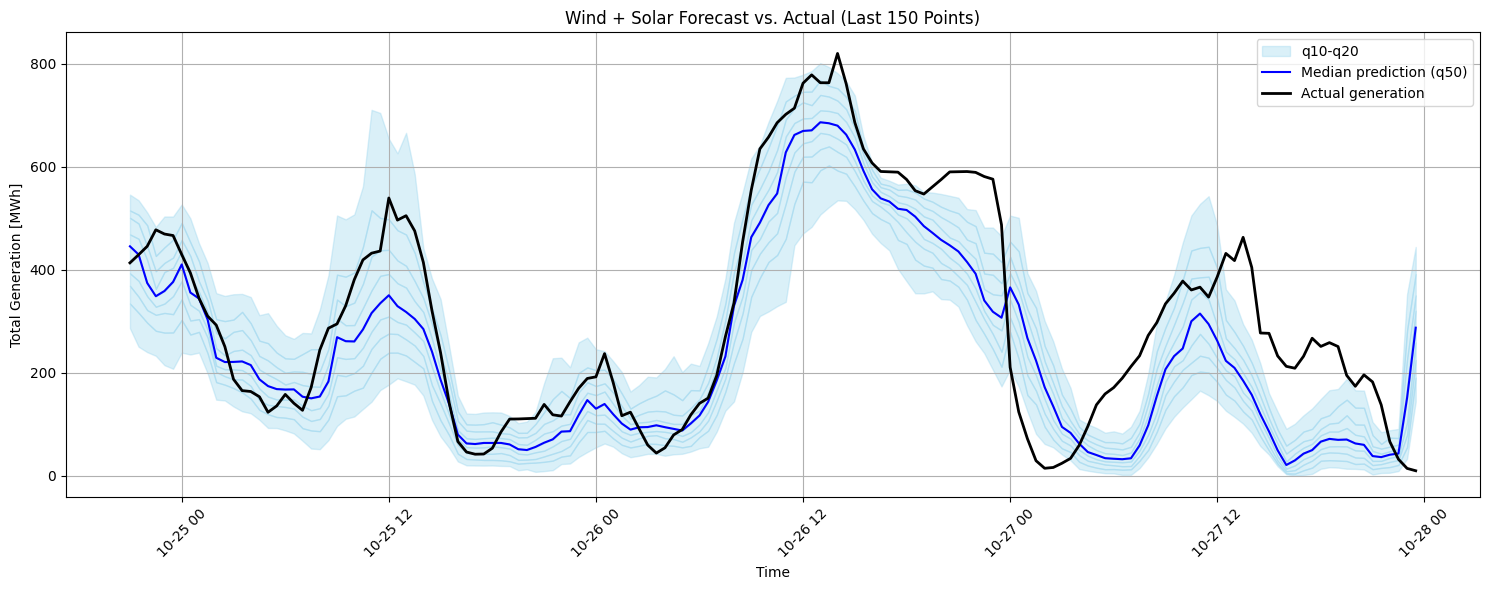

In [22]:
# Show results for qunatie forest for the last 150 point
N = 150 
plot_df = df_preds.tail(N).reset_index(drop=True)
time_axis = t_test.tail(N).reset_index(drop=True)

plt.figure(figsize=(15, 6))

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

# Plot quantile bands
for lower, upper in zip(range(10, 90, 10), range(20, 100, 10)):
    plt.fill_between(
        time_axis,
        plot_df[f"q{lower}"],
        plot_df[f"q{upper}"],
        color="skyblue",
        alpha=0.3,
        label=f"q{lower}-q{upper}" if lower == 10 else None
    )

# Median prediction
plt.plot(time_axis, plot_df["q50"], label="Median prediction (q50)", color="blue")

# Actual generation
plt.plot(time_axis, plot_df["total_generation_MWh"], label="Actual generation", color="black", linewidth=2)

plt.title("Wind + Solar Forecast vs. Actual (Last 150 Points)")
plt.xlabel("Time")
plt.ylabel("Total Generation [MWh]")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate for readability
plt.tight_layout()
plt.show()


In [30]:
# prepross_comp
# note comp runs from feb to apr 2024 

# get X and y for testing with competition
start_date_comp = pd.Timestamp("2024-02-20 00:00:00+00:00")
end_date_comp = pd.Timestamp("2024-05-19 23:30:00+00:00")

# Extract y 
energy_data_2 = pd.read_csv("data_comp/Energy_Data_20240119_20240519.csv")
energy_data_2["dtm"] = pd.to_datetime(energy_data_2["dtm"])

# take out desierd interval 
filtered_data = energy_data_2[
    (energy_data_2["dtm"] >= start_date_comp) &
    (energy_data_2["dtm"] <= end_date_comp)
].copy()

filtered_data["Wind_MWh_credit"] = 0.5*filtered_data["Wind_MW"] - filtered_data["boa_MWh"]
filtered_data["Solar_MWh_credit"] = 0.5*filtered_data["Solar_MW"]
filtered_data["total_generation_MWh"] = filtered_data["Wind_MWh_credit"] + filtered_data["Solar_MWh_credit"]

# Double checking data
#has_nans = filtered_data["total_generation_MWh"].isna().any()
#print("Contains NaNs:", has_nans) # no NaNs good 
#display(filtered_data)

y_true_comp = filtered_data["total_generation_MWh"].values

# Extract X_test_comp 

model_table = pd.read_csv("data_comp/forecast_data_merged_comp.csv")
# convert to datetime
model_table["reference_time"] = pd.to_datetime(model_table["reference_time"])
model_table["valid_time"] = pd.to_datetime(model_table["valid_time"])

# copy previous methods 
X_latest_forcast_comp = pd.DataFrame() 
first_day = pd.Timestamp("2024-01-29 00:00:00+00:00")
num_day = model_table["reference_time"].dt.date.nunique()

for d in range(num_day):
       start = (first_day + timedelta(hours=18)) + timedelta(days=d)
       end = start + timedelta(hours=24)
       mask = (model_table["reference_time"] == start) &\
              (model_table["valid_time"] >= start + timedelta(hours=6)) &\
              (model_table["valid_time"] < end + + timedelta(hours=6))
       X_latest_forcast_comp = pd.concat([X_latest_forcast_comp, model_table.loc[mask]])

X_latest_forcast_comp = X_latest_forcast_comp.rename(columns={
    "valid_time": "valid_datetime"})

X_raw = model_table.copy()

X_raw["target_day"] = X_raw["valid_time"].dt.date
X_raw["reference_day"] = X_raw["reference_time"].dt.date
X_raw_filtered = X_raw[X_raw["reference_day"] == (X_raw["target_day"] - pd.Timedelta(days=1))]

X_overlapp_mean_comp = X_raw_filtered.groupby("valid_time", as_index=False).agg({
    "dwd_RelativeHumidity": "mean",
    "dwd_WindDirection_100": "mean",
    "dwd_WindSpeed_100": "mean",	
    "dwd_CloudCover": "mean",
    "dwd_SolarDownwardRadiation": "mean",	
    "dwd_Temperature": "mean",
    "ncep_RelativeHumidity": "mean",
    "ncep_WindDirection_100": "mean",
    "ncep_WindSpeed_100": "mean",
    "ncep_CloudCover": "mean",	
    "ncep_SolarDownwardRadiation": "mean",	
    "ncep_Temperature": "mean",
    "reference_time": ["first", "count"] 
})

X_overlapp_mean_comp.columns = [
    "_".join(col) if isinstance(col, tuple) else col 
    for col in X_overlapp_mean.columns
]

X_overlapp_mean_comp = X_overlapp_mean_comp.rename(columns={
    "reference_time_first": "ref_datetime",
    "reference_time_count": "n_forecasts",
    "dwd_RelativeHumidity_mean": "dwd_RelativeHumidity",
    "dwd_WindDirection_100_mean": "dwd_WindDirection_100",
    "dwd_WindSpeed_100_mean": "dwd_WindSpeed_100",
    "dwd_CloudCover_mean": "dwd_CloudCover",
    "dwd_SolarDownwardRadiation_mean": "dwd_SolarDownwardRadiation",	
    "dwd_Temperature_mean": "dwd_Temperature",
    "ncep_RelativeHumidity_mean": "ncep_RelativeHumidity",
    "ncep_WindDirection_100_mean": "ncep_WindDirection_100",
    "ncep_WindSpeed_100_mean": "ncep_WindSpeed_100",
    "ncep_CloudCover_mean": "ncep_CloudCover",
    "ncep_SolarDownwardRadiation_mean": "ncep_SolarDownwardRadiation",
    "ncep_Temperature_mean": "ncep_Temperature",
    "valid_time_": "valid_datetime"
})

# take out intervalls
filtered_X_lf = X_latest_forcast_comp[(X_latest_forcast_comp["valid_datetime"] >= start_date_comp) & (X_latest_forcast_comp["valid_datetime"] <= end_date_comp)]
filtered_X_mo = X_overlapp_mean_comp[(X_overlapp_mean_comp["valid_datetime"] >= start_date_comp) & (X_overlapp_mean_comp["valid_datetime"] <= end_date_comp)]

# split into solar and wind 
wind_features = ["valid_datetime", "dwd_RelativeHumidity", "dwd_WindDirection_100", "dwd_WindSpeed_100",
                "ncep_RelativeHumidity", "ncep_WindDirection_100", "ncep_WindSpeed_100"]

solar_features = ["valid_datetime","dwd_CloudCover", "dwd_SolarDownwardRadiation", "dwd_Temperature",
                "ncep_CloudCover", "ncep_SolarDownwardRadiation", "ncep_Temperature"]

X_comp_solar_lf = filtered_X_lf[solar_features]
X_comp_wind_lf = filtered_X_lf[wind_features]
X_comp_solar_mo = filtered_X_mo[solar_features]
X_comp_wind_mo = filtered_X_mo[wind_features]

# fitt transform
#X_comp_solar_lf_scaled = filtered_X_lf[solar_features]
#X_comp_wind_lf_scaled = filtered_X_lf[wind_features]
X_comp_solar_scaled = feature_engineering_solar.transform(X_comp_solar_lf)
X_comp_wind_scaled = feature_engineering_wind.transform(X_comp_wind_lf)

In [41]:
# Cool we compair with comp 
print("predicting solar")
y_p_solar = rfq_solar.predict(X_comp_solar_scaled, quantiles=quant)

print("predicting wind")
y_p_wind = rfq_wind.predict(X_comp_wind_scaled, quantiles=quant)

y_p_wind_unscaled_comp = y_wind_scale.inverse_transform(y_p_wind)
y_p_solar_unscaled_comp = y_sun_scale.inverse_transform(y_p_solar)
y_p_scaled_comp = y_p_wind_unscaled_comp + y_p_solar_unscaled_comp


df_preds = pd.DataFrame(y_p_scaled_comp, columns=[f"q{int(q*100)}" for q in quant])

df_preds["total_generation_MWh"] = y_true_comp

score = pinball_score(df_preds)
print(f"Pinball score (wind + solar): {score:.4f}")
# lf with scaled y

predicting solar
predicting wind
Pinball score (wind + solar): 48.2217


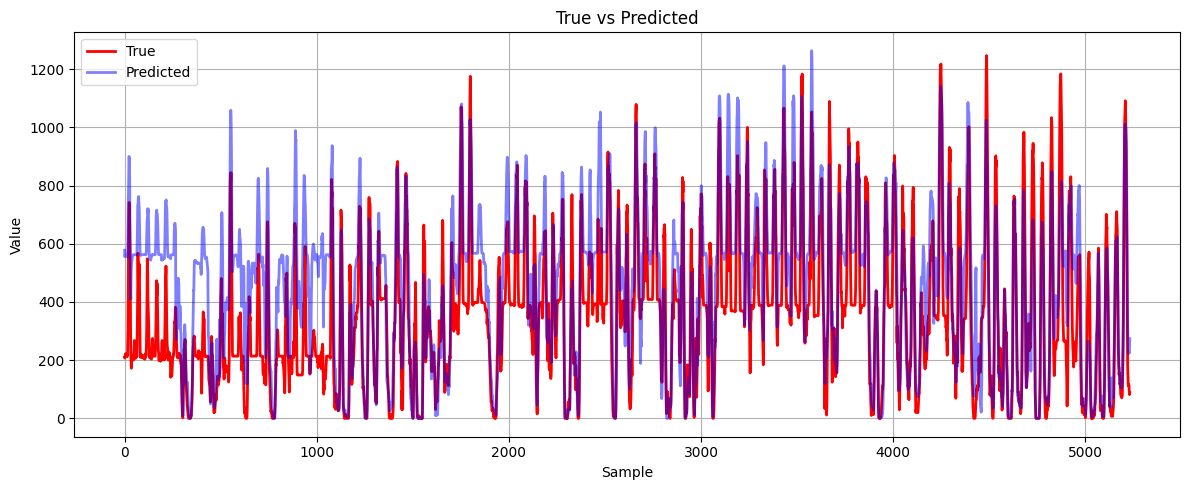

array([1.91793594e-03, 1.34225310e-02, 1.63236650e-03, 1.23424232e-03,
       2.06365511e-03, 2.92222534e-03, 2.52417485e-03, 1.66099475e-03,
       1.54253308e-03, 1.92299707e-03, 3.07652809e-03, 1.82429636e-03,
       2.11483398e-03, 1.37261003e-01, 7.84769038e-01, 2.73407595e-03,
       1.87133219e-03, 9.08118277e-04, 7.41232364e-04, 7.58148780e-04,
       1.35898603e-03, 2.17175263e-03, 1.55089320e-03, 1.26502942e-03,
       1.23968966e-03, 2.03486830e-03, 2.94167414e-03, 4.19219493e-03,
       6.19222552e-03, 3.07076270e-03, 2.15894101e-03, 1.80935176e-03,
       8.73923237e-04, 6.89367913e-04, 6.68309216e-04, 8.79766935e-04])

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(y_true_comp, label='True', linewidth=2,  color="red")
plt.plot(df_preds["q50"].values, label='Predicted', linewidth=2, color="blue", alpha=0.5)

plt.title("True vs Predicted")
plt.xlabel("Sample")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


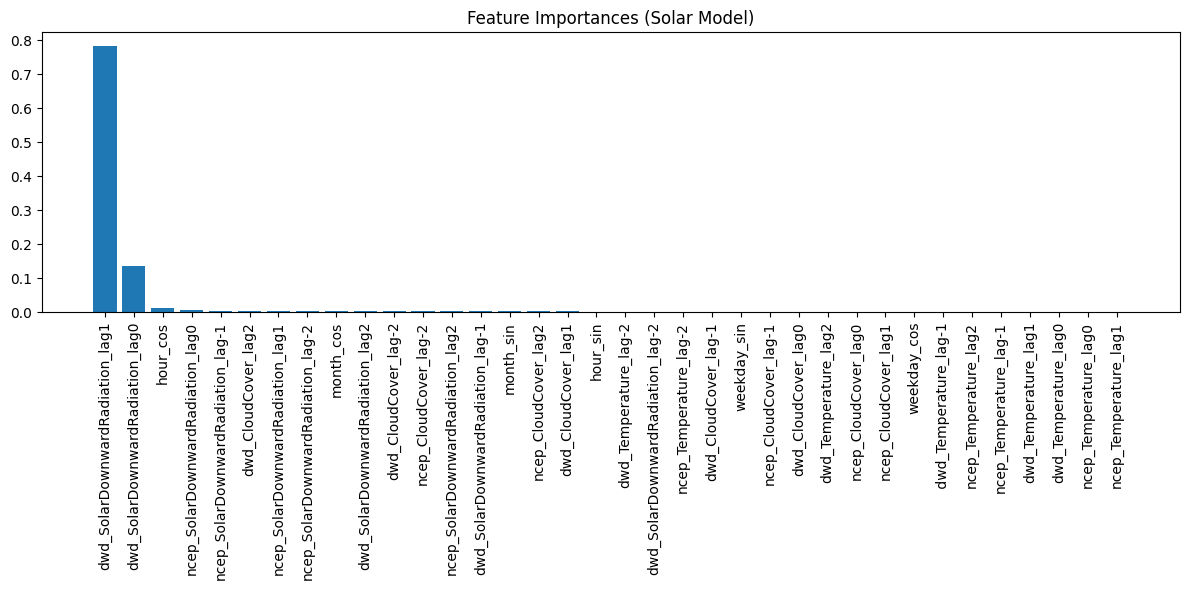

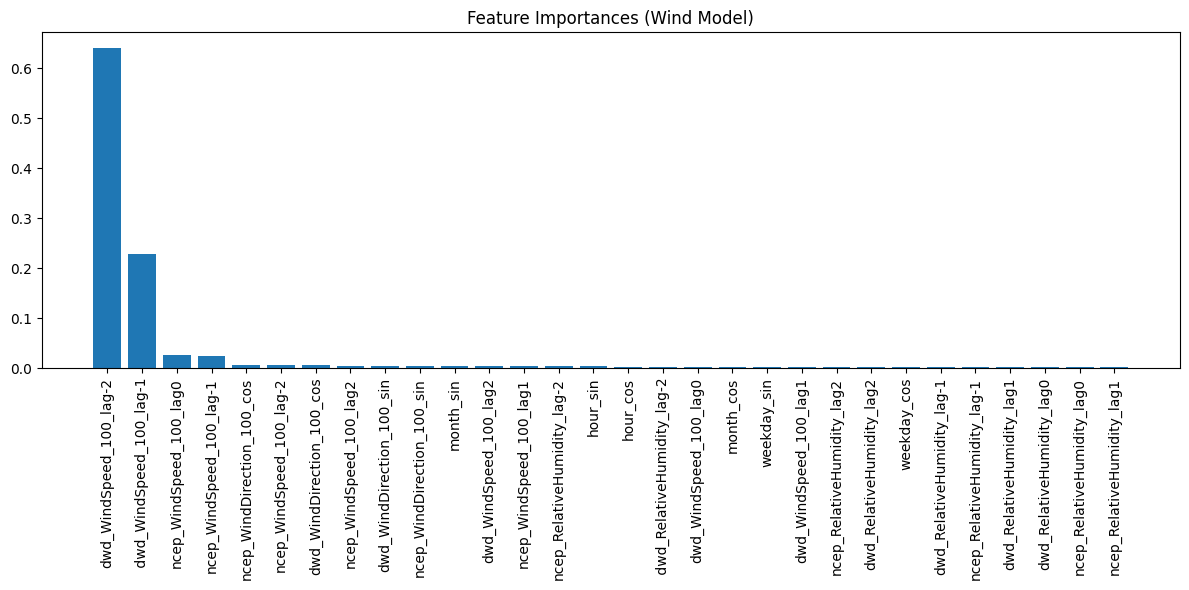

In [102]:
feature_names = ["hour_sin", "hour_cos", "weekday_sin", "weekday_cos", "month_sin", "month_cos", "dwd_CloudCover_lag-2", "dwd_CloudCover_lag-1", "dwd_CloudCover_lag0", "dwd_CloudCover_lag1", "dwd_CloudCover_lag2", "dwd_SolarDownwardRadiation_lag-2", "dwd_SolarDownwardRadiation_lag-1", "dwd_SolarDownwardRadiation_lag0", "dwd_SolarDownwardRadiation_lag1", "dwd_SolarDownwardRadiation_lag2", "dwd_Temperature_lag-2"," dwd_Temperature_lag-1", "dwd_Temperature_lag0", "dwd_Temperature_lag1", "dwd_Temperature_lag2", "ncep_CloudCover_lag-2", "ncep_CloudCover_lag-1", "ncep_CloudCover_lag0", "ncep_CloudCover_lag1", "ncep_CloudCover_lag2", "ncep_SolarDownwardRadiation_lag-2", "ncep_SolarDownwardRadiation_lag-1", "ncep_SolarDownwardRadiation_lag0", "ncep_SolarDownwardRadiation_lag1", "ncep_SolarDownwardRadiation_lag2", "ncep_Temperature_lag-2", "ncep_Temperature_lag-1", "ncep_Temperature_lag0", "ncep_Temperature_lag1", "ncep_Temperature_lag2"]
# Get importances
importances = rfq_solar.feature_importances_

# Sort and plot
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title("Feature Importances (Solar Model)")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

feature_names = ["hour_sin", "hour_cos", "weekday_sin", "weekday_cos", "month_sin", "month_cos", "dwd_WindDirection_100_sin", "dwd_WindDirection_100_cos", "ncep_WindDirection_100_sin", "ncep_WindDirection_100_cos"," dwd_RelativeHumidity_lag-2", "dwd_RelativeHumidity_lag-1", "dwd_RelativeHumidity_lag0", "dwd_RelativeHumidity_lag1", "dwd_RelativeHumidity_lag2", "dwd_WindSpeed_100_lag-2"," dwd_WindSpeed_100_lag-1", "dwd_WindSpeed_100_lag0", "dwd_WindSpeed_100_lag1", "dwd_WindSpeed_100_lag2", "ncep_RelativeHumidity_lag-2", "ncep_RelativeHumidity_lag-1", "ncep_RelativeHumidity_lag0", "ncep_RelativeHumidity_lag1", "ncep_RelativeHumidity_lag2", "ncep_WindSpeed_100_lag-2", "ncep_WindSpeed_100_lag-1", "ncep_WindSpeed_100_lag0", "ncep_WindSpeed_100_lag1", "ncep_WindSpeed_100_lag2"]

importances = rfq_wind.feature_importances_

# Sort and plot
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title("Feature Importances (Wind Model)")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

Okay the prediction is absolute ass, so let's try and take REMIT into account.

In [ ]:
import pandas as pd
import xarray as xr
import numpy as np
import warnings
import json
warnings.simplefilter(action='ignore', category=FutureWarning)

start_date = pd.Timestamp("2024-02-20 00:00:00+00:00")
end_date = pd.Timestamp("2024-05-19 23:30:00+00:00")

# create df 
date_range = pd.date_range(start=start_date, end=end_date, freq="30min", tz="UTC")
df = pd.DataFrame({'dtm': date_range})
df["capacity_1"] = np.nan
df["capacity_2"] = np.nan
df["capacity_3"] = np.nan

# open remit files
with open("data_comp/REMIT/T_HOWAO-1-2023-05-20T00_00_00.000Z-2024-05-20T00_00_00.000Z.json", "r") as file:
    remit_data_1 = json.load(file)
with open("data_comp/REMIT/T_HOWAO-2-2023-05-20T00_00_00.000Z-2024-05-20T00_00_00.000Z.json", "r") as file:
    remit_data_2 = json.load(file)
with open("data_comp/REMIT/T_HOWAO-3-2023-05-20T00_00_00.000Z-2024-05-20T00_00_00.000Z.json", "r") as file:
    remit_data_3 = json.load(file)

def get_publish_time(item):
    publish_time = item.get("publishTime")
    if publish_time is None:
        return pd.NaT  # Not a Time, will be sorted last
    try:
        return pd.Timestamp(publish_time)
    except:
        return pd.NaT

def round_to_nearest_half_hour(dt):
    dt = pd.Timestamp(dt)
    discard = pd.Timedelta(minutes=dt.minute % 30,
                           seconds=dt.second,
                           microseconds=dt.microsecond)
    dt -= discard
    if discard >= pd.Timedelta(minutes=15):
        dt += pd.Timedelta(minutes=30)
    return dt

# filter out for start and end dates 
filtered_data_1 = []
for item in remit_data_1:
    for profile in item.get("outageProfile", []):
        profile_start = pd.Timestamp(profile["startTime"])
        profile_end = pd.Timestamp(profile["endTime"])
        
        if profile_end >= start_date and profile_start <= end_date:
            filtered_data_1.append(item)
            break

filtered_data_2 = []
for item in remit_data_2:
    for profile in item.get("outageProfile", []):
        profile_start = pd.Timestamp(profile["startTime"])
        profile_end = pd.Timestamp(profile["endTime"])
        
        if profile_end >= start_date and profile_start <= end_date:
            filtered_data_2.append(item)
            break

filtered_data_3 = []
for item in remit_data_3:
    for profile in item.get("outageProfile", []):
        profile_start = pd.Timestamp(profile["startTime"])
        profile_end = pd.Timestamp(profile["endTime"])
        
        if profile_end >= start_date and profile_start <= end_date:
            filtered_data_3.append(item)
            break

# Sort the filtered data
sorted_filtered_data_1 = sorted(
    filtered_data_1,
    key=lambda x: get_publish_time(x),
    reverse=False  # Set to True for descending order
)

sorted_filtered_data_2 = sorted(
    filtered_data_2,
    key=lambda x: get_publish_time(x),
    reverse=False  # Set to True for descending order
)

sorted_filtered_data_3 = sorted(
    filtered_data_3,
    key=lambda x: get_publish_time(x),
    reverse=False  # Set to True for descending order
)

print("-"*50)
# store data in df 
for item in filtered_data_1:
    for profile in item.get("outageProfile", []):
        # Round start and end times
        start = round_to_nearest_half_hour(profile["startTime"])
        end = round_to_nearest_half_hour(profile["endTime"])

        # Skip if interval is fully outside the window
        if end < start_date or start > end_date:
            continue

        # Define mask and fill in capacity
        mask = (df["dtm"] >= start) & (df["dtm"] <= end)

        existing = df.loc[mask, "capacity_1"]
        new_value = profile["capacity"]
        conflict = (existing.notna()) & (existing != new_value)
        if conflict.any():
            print(f"Conflict at {start} - {end}: existing values differ from new capacity {new_value}")
        df.loc[mask, "capacity_1"] = profile["capacity"]


print("-"*50)
for item in filtered_data_2:
    for profile in item.get("outageProfile", []):
        # Round start and end times
        start = round_to_nearest_half_hour(profile["startTime"])
        end = round_to_nearest_half_hour(profile["endTime"])

        # Skip if interval is fully outside the window
        if end < start_date or start > end_date:
            continue

        # Define mask and fill in capacity
        mask = (df["dtm"] >= start) & (df["dtm"] <= end)

        existing = df.loc[mask, "capacity_2"]
        new_value = profile["capacity"]
        conflict = (existing.notna()) & (existing != new_value)
        if conflict.any():
            print(f"Conflict at {start} - {end}: existing values differ from new capacity {new_value}")
        df.loc[mask, "capacity_2"] = profile["capacity"]


print("-"*50)
for item in filtered_data_3:
    for profile in item.get("outageProfile", []):
        # Round start and end times
        start = round_to_nearest_half_hour(profile["startTime"])
        end = round_to_nearest_half_hour(profile["endTime"])

        # Skip if interval is fully outside the window
        if end < start_date or start > end_date:
            continue

        # Define mask and fill in capacity
        mask = (df["dtm"] >= start) & (df["dtm"] <= end)

        existing = df.loc[mask, "capacity_3"]
        new_value = profile["capacity"]
        conflict = (existing.notna()) & (existing != new_value)
        if conflict.any():
            print(f"Conflict at {start} - {end}: existing values differ from new capacity {new_value}")
        df.loc[mask, "capacity_3"] = profile["capacity"]


# fill NaNs with zeros
df.update(df[["capacity_1", "capacity_2", "capacity_3"]].fillna(0))
df["capacity_tot"] = df["capacity_1"] + df["capacity_2"] + df["capacity_3"]

#df.to_csv("data_comp/REMIT_capacity_comp.csv")

--------------------------------------------------
Conflict at 2024-01-30 12:00:00+00:00 - 2024-05-15 19:00:00+00:00: existing values differ from new capacity 232
Conflict at 2024-05-02 08:00:00+00:00 - 2024-05-14 16:00:00+00:00: existing values differ from new capacity 200
Conflict at 2024-01-30 12:00:00+00:00 - 2024-05-02 09:00:00+00:00: existing values differ from new capacity 232
Conflict at 2024-05-02 09:00:00+00:00 - 2024-05-11 16:00:00+00:00: existing values differ from new capacity 0
Conflict at 2024-05-11 16:00:00+00:00 - 2024-05-14 16:00:00+00:00: existing values differ from new capacity 200
Conflict at 2024-01-30 12:00:00+00:00 - 2024-05-03 09:00:00+00:00: existing values differ from new capacity 232
Conflict at 2024-05-03 09:00:00+00:00 - 2024-05-12 16:00:00+00:00: existing values differ from new capacity 0
Conflict at 2024-05-12 16:00:00+00:00 - 2024-05-15 16:00:00+00:00: existing values differ from new capacity 200
Conflict at 2024-01-30 12:00:00+00:00 - 2024-05-04 09:00:

Pinball score (REMI tot): 31.5231


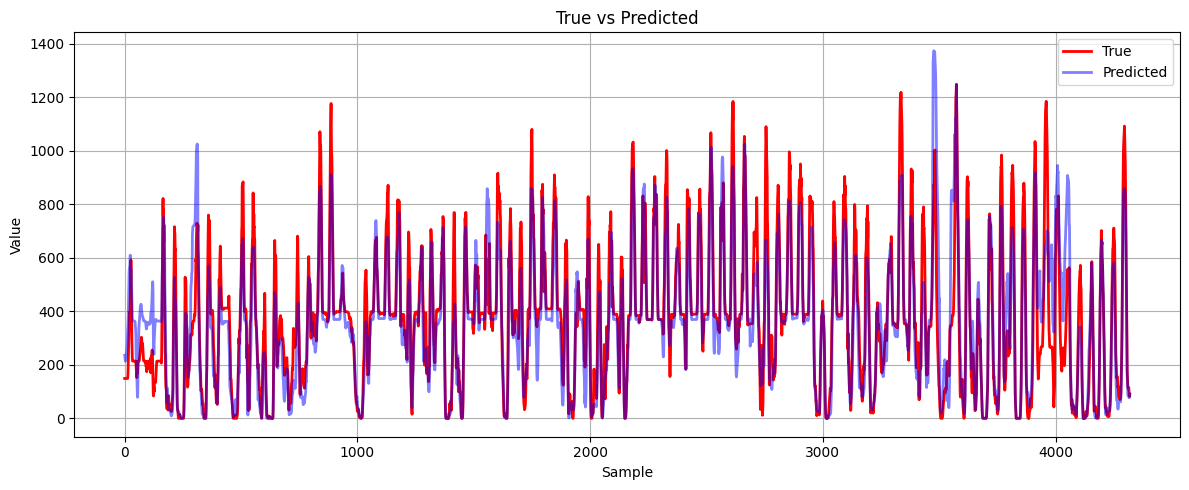

In [51]:
#display(df)
#display(filtered_data_1) #   'normalCapacity': 400,
#display(filtered_data_2) #   'normalCapacity': 400,
#display(filtered_data_3) #   'normalCapacity': 400,
df["capacity_1_scaled"] = df["capacity_1"]/(400)
df["capacity_2_scaled"] = df["capacity_2"]/(400)
df["capacity_3_scaled"] = df["capacity_3"]/(400)
df["capacity_tot_scaled"] = df["capacity_tot"]/(1200)*2.604
#print(df_preds.shape)
#display(df_preds)

y_p_wind_scaled = y_p_wind_unscaled_comp*df["capacity_tot_scaled"].to_numpy()[:, np.newaxis]

y_p_comp_2 = y_p_solar_unscaled_comp + y_p_wind_scaled

df_preds_2 = pd.DataFrame(y_p_comp_2, columns=[f"q{int(q*100)}" for q in quant])

df_preds_2["total_generation_MWh"] = y_true_comp

score = pinball_score(df_preds_2)
print(f"Pinball score (REMI tot): {score:.4f}")

plt.figure(figsize=(12, 5))
plt.plot(y_true_comp, label='True', linewidth=2,  color="red")
plt.plot(df_preds_2["q50"].values, label='Predicted', linewidth=2, color="blue", alpha=0.5)

plt.title("True vs Predicted")
plt.xlabel("Sample")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Extra knäck 
# scale targets
# implement Remit for wind

In [24]:
display(filtered_data_3)

[{'id': 710072,
  'dataset': 'REMIT',
  'mrid': '11XDONG-PT-----2-NGET-RMT-00001806',
  'revisionNumber': 2,
  'publishTime': '2024-01-30T09:22:01Z',
  'createdTime': '2024-01-30T09:16:00Z',
  'messageType': 'UnavailabilitiesOfElectricityFacilities',
  'messageHeading': 'REMIT Information',
  'eventType': 'Production unavailability',
  'unavailabilityType': 'Planned',
  'participantId': 'DONG013',
  'registrationCode': '11XDONG-PT-----2',
  'assetId': 'T_HOWAO-3',
  'assetType': 'Production',
  'affectedUnit': 'HOWAO-3',
  'affectedUnitEIC': '48W00000HOWAO-3I',
  'affectedArea': 'B7',
  'biddingZone': '10YGB----------A',
  'fuelType': 'Wind Offshore',
  'normalCapacity': 400,
  'availableCapacity': 150,
  'unavailableCapacity': 250,
  'eventStatus': 'Active',
  'eventStartTime': '2024-01-29T02:10:00Z',
  'eventEndTime': '2024-02-17T18:00:00Z',
  'cause': 'Planned Outage',
  'relatedInformation': 'MW will fluctuate between 150mw and 280mw due to a fault on the export cable',
  'outagePr